<center><h1><font color=yellow size=40px>Tutorial about shortest path prediction with GCNs</font></h1></center>
<br>
<br>
<center><img src="https://raw.githubusercontent.com/AlbertoZandara/GCN/main/Misc/alina-grubnyak-ZiQkhI7417A-unsplash.jpg"/></center>

In this notebook it is presented an original approach to predict the shortest path between to nodes in a graph using a Graph Convolutional Neural Network. The pipeline is based on the model introduced by Thomas Kipf in 2017, specifically adapted and implemented for shortest path prediction.

## Scripts upload

In first instance it is necessary to upload the libraries from the Kipf GCN Model in order to take advantage of that stucture.

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir /content/gcn

In [ ]:
! mv __init__.py gcn
! mv inits.py gcn
! mv layers.py gcn
! mv metrics.py gcn
! mv models.py gcn
! mv train.py gcn
! mv utils.py gcn

## Importing libraries

In [ ]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.inits import *
from gcn.models import Model,MLP
from gcn.layers import *

import scipy as sp
from scipy import sparse
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Graph initialization

In this phase the dataset is initialized. It consists on 35000 graphs of 20 nodes not connected between each other. It is generated with Networkx as a "partition graph". A partition graph is a graph of subgraphs of defined size (20 in this case) where the nodes belonging to the same subgraph are connected with probability $P_{in}$ (0.3 in this case) and the different subgraphs are connected with probability $P_{out}$ (0 in this case). 
<br>
<br>

***WARNING: To perform this notebook at least 25GB of RAM memory are required!***

In [ ]:
num_community = 35000                                     #Definition of the number of subgraphs in the graph
node = [20 for i in range(num_community)]                 #Definition of the number of nodes for every subgraph
GG = nx.random_partition_graph(node,.3,.0,seed=123)       #Definition of the graph with networkx, the probability of interconnection between partitions in .0 so all the partitions are isolated
adj_GG = np.zeros((num_community, num_community))         #Definition of a matrix 35000x35000, the partitions are assumed to nodes
for edge in GG.edges():
    row = edge[0] // num_community                        #Belonging partition of the origin node
    col = edge[1] // num_community                        #Belonging partition of the destination node
    if row != col:                                        #If the partitions of appartenence are different put a 1 in the relative cell
        adj_GG[row][col]=1                                
        adj_GG[col][row]=1
    
adj_sparse = sparse.csr_matrix(adj_GG)                    #Adjaciency matrix of the communities

## Compiling features

After the initializzation of the graph it is necessary to compile the features matrix. In a partition graphs each partition is considered as a single node (35000 in this case). For this reason it is necessary to fill in the features matrix of each partition (just like a node) the adjaciency matrix of the specific partition.

In [ ]:
partition = GG.graph['partition']                           #This is another graph with 35000 nodes in which subgraphs are assumed as nodes. Is a container of nodes 

In [ ]:
adjlist = [[]]
for i in range(len(partition)):                             #len(partition) is 35000
    H = GG.subgraph(partition[i])                           #the i-th subgraph
    adj = nx.adjacency_matrix(H).todense().tolist()         #Is a python list containing the adjaciency matrix 2D
    for element in adj:
        adjlist[i].extend(element)                          #Is a 2D matrix with the adjaciency matrix (reported as a list) of the i-th subgraph in the i-th raw
    adjlist.append([])
    
adjlist = adjlist[:-1]
adj_input = np.array(adjlist)
features_sparse = sparse.csr_matrix(adj_input)

In [ ]:
path = []                                                    #Is a vector of 35000 components. It contains the shortest path between node 1 and 20 for each partition
for i in range(num_community):
    try:
        path.append([nx.shortest_path(GG.subgraph(partition[i]), source=i*20, target=(i+1)*20-1)[1]-i*20])
    except:
        path.append([0])

## Compiling labels

Now it is necessary to associate the right output to each subgraph. 

The target is to obtain a network able to recognize the shortest path between 2 nodes. The problem lies in the fact that the output of the netwotk is normalized and has a defined size. 
The easier way to resolve this problem is using a network able to recognize the first node of the shortest path sequence and use this network iteratively until the output node correspond to the required destination.

In this way the output has a precise dimension, a vector of 19 components (one for each node), and the following node is indicated with one-hot encoding. 

In [ ]:
#The labels are divided for each dataset (training, validation and testing)

Train_path = path[:int(num_community*0.6)]
Validation_path = path[int(num_community*0.6):int(num_community*0.8)]
Test_path = path[int(num_community*0.8):]

In [ ]:
#One-hot encoding of path length

Label_Train = np.zeros((int(num_community*0.6),19))
Label_Test = np.zeros((int(num_community*0.2),19))
Label_Val = np.zeros((int(num_community*0.2),19))


for j in range(0,len(Train_path)):
    i=Train_path[j][0]
    Label_Train[j][i-1] = 1

for j in range(0,len(Validation_path)):
    i=Validation_path[j][0]
    Label_Val[j][i-1] = 1

for j in range(0,len(Test_path)):
    i=Test_path[j][0]
    Label_Test[j][i-1] = 1
    
label_tv = np.concatenate((Label_Train, Label_Val)) 
labels = np.concatenate((label_tv, Label_Test)) 

## Unlabeling

Following the intended behavior of the Kipf model, it will be trained on both labeled and unlabeled examples (i.e. in the training phase the validation and test datasets will be unlabeled) and later will be evaluated the predictions of the trained model on previously unlabeled examples. 

In this setting, the model always performs a forward pass on the full dataset and it is required a mask that affects which labels are available to the model during the different phases. All other nodes are treated as **unlabeled** nodes.

In [ ]:
def sample_mask(idx, l):                                    #Create a bolean array for every dataset (train, val, test) to use as a mask filter for the labels
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


train_size = int(num_community*0.6)                         #Different sizes of the different datasets
val_size = int(num_community*0.2)
test_size = int(num_community*0.2)


idx_train = range(train_size)                               #Vectors containing the indexes of the labeled subgraphs
idx_val = range(train_size, train_size+val_size)
idx_test = range(train_size+val_size, train_size+val_size+test_size)


train_mask = sample_mask(idx_train, labels.shape[0])        #Masks that are true where indicated by the indexes vectors, false otherwise
val_mask = sample_mask(idx_val, labels.shape[0])
test_mask = sample_mask(idx_test, labels.shape[0])


y_train = np.zeros(labels.shape)                            #The datasets are all the same size
y_val = np.zeros(labels.shape)
y_test = np.zeros(labels.shape)
y_train[train_mask, :] = labels[train_mask, :]              #But unlabeled where indicated by the mask
y_val[val_mask, :] = labels[val_mask, :]
y_test[test_mask, :] = labels[test_mask, :]

## Model initialization

Now is time to define the morphology and the dictionary for the *Graph Convolutional Neural Network* that will be deployed for this application.

The structure is exactly the same introduced by Kipf in 2017 but empirically it has been determined the internal structure with 2 hidden layers of 1024 components.

In [ ]:
adj = adj_sparse
features = features_sparse   
y_train = y_train 
y_val = y_val
train_mask = train_mask
val_mask = val_mask

In [ ]:
#Slightly modified version of Kipf 2017 Model

class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=FLAGS.hidden2,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,                      
                                            dropout=True,
                                            logging=self.logging))
        
        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden2,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

## Data preprocessing

As mentioned in the theoretical section of the paper associated to this notebook, the data need to be preprocessed before give it to the network following the normalization: 

<center>$\widetilde D^{-\frac{1}{2}} \widetilde A \widetilde D^{-\frac{1}{2}}$</center>

In [ ]:
def sparse_to_tuple(sparse_mx):
    def to_tuple(mx):
        if not sp.sparse.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


    
#The power of a diagonal matrix is the power of each component so D is generated from A summing all the rows, in this way every single component of the vector can be simply elevated

def normalize_adj(adj): 
    adj = sp.sparse.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))                           #Sum every column cell for each row, in this direction ->. So the result is a vector with as many cell as the number of raws (35000 in this case)
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.sparse.diags(d_inv_sqrt, 0)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()



#Simply following the formula A' is the sum of A+I

def preprocess_adj(adj):
    adj_normalized = normalize_adj(adj + sp.sparse.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)



num_supports = 1
model_func = GCN
support = [preprocess_adj(adj)]

In [ ]:
def preprocess_features(features):
    rowsum = np.array(features.sum(1))                      #Sum of the columns
    r_inv1 = np.power(rowsum, -0.5).flatten()
    r_inv2 = np.power(rowsum, -0.5).flatten()
    r_inv = np.multiply(r_inv1, r_inv2)
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.sparse.diags(r_inv, 0)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


features = preprocess_features(features)

In [ ]:
features                                                    #In the first array are contained the adjacency matrices of every subgraph. 
                                                            #To every subgraph edge is indicated a weight that rappresents the total number of edges in the i-th subgraph.

(array([[    0,   396],
        [    0,   390],
        [    0,   386],
        ...,
        [34999,     9],
        [34999,     5],
        [34999,     3]], dtype=int32),
 array([0.00892857, 0.00892857, 0.00892857, ..., 0.00892857, 0.00892857,
        0.00892857]),
 (35000, 400))

## Training pipeline

The title is pretty comprehensive. According to the Kipf design in this phase all the required variables are initialized and the model is trained using the datasets built and processed before.

In [ ]:
#Set random seed

seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)



#Settings

flags = tf.app.flags
FLAGS = flags.FLAGS



#Definition of network and training parameters

flags.DEFINE_string('model', 'gcn', 'Model string.')  
flags.DEFINE_float('learning_rate', 1e-3, 'Initial learning rate.')

flags.DEFINE_integer('epochs', 1000, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 1024, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 1024, 'Number of units in hidden layer 2.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')

flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')

flags.DEFINE_integer('early_stopping', 300, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [ ]:
def masked_softmax_cross_entropy(preds, labels, mask):                       #Softmax cross-entropy loss with masking
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_mean_square_error(preds,labels,mask):                             #L-2 loss
    loss = tf.nn.l2_loss(preds - labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(preds, labels, mask):                                    #Accuracy with masking
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [ ]:
#Extraction of the network configuration parameters

remaining_args = FLAGS([sys.argv[0]] + [flag for flag in sys.argv if flag.startswith("--")])
assert(remaining_args == [sys.argv[0]])
if (FLAGS.model == 'gcn'):
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)] 
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))



#Definition of placeholders as provided by Kipf

tf.compat.v1.disable_eager_execution()
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}



#Declaration of the model

model = model_func(placeholders, input_dim=features[2][1], logging=True)



#Session initialization

sess = tf.Session()



#Definition of the model evaluation function

def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
#Same as Kipf 2017, function to compile the training dictionary

def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict

In [ ]:
#Initialization of the session

sess.run(tf.global_variables_initializer())
train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


#Training

for epoch in range(FLAGS.epochs):

    t = time.time()                                                                         #Compilation of the dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)        #Training steps
    
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)        #Validation steps
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Training completed!")

Epoch: 0001 train_loss= 3.08878 train_acc= 0.04348 val_loss= 3.07392 val_acc= 0.30600 time= 6.08079
Epoch: 0002 train_loss= 3.07144 train_acc= 0.29824 val_loss= 3.05899 val_acc= 0.30600 time= 5.71811
Epoch: 0003 train_loss= 3.05377 train_acc= 0.29824 val_loss= 3.04165 val_acc= 0.30600 time= 5.64456
Epoch: 0004 train_loss= 3.03398 train_acc= 0.29824 val_loss= 3.01995 val_acc= 0.30600 time= 5.68233
Epoch: 0005 train_loss= 3.01027 train_acc= 0.29824 val_loss= 2.99190 val_acc= 0.30600 time= 5.63667
Epoch: 0006 train_loss= 2.98128 train_acc= 0.29824 val_loss= 2.95561 val_acc= 0.30600 time= 5.69901
Epoch: 0007 train_loss= 2.94450 train_acc= 0.29824 val_loss= 2.90982 val_acc= 0.30600 time= 5.67964
Epoch: 0008 train_loss= 2.89970 train_acc= 0.29824 val_loss= 2.85468 val_acc= 0.30600 time= 5.65176
Epoch: 0009 train_loss= 2.84699 train_acc= 0.29824 val_loss= 2.79320 val_acc= 0.30600 time= 5.70250
Epoch: 0010 train_loss= 2.78958 train_acc= 0.29824 val_loss= 2.73334 val_acc= 0.30600 time= 5.68180


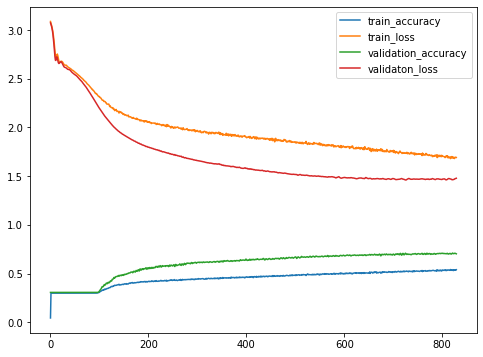

In [ ]:
#Visualization of the training progress

plt.figure(figsize=(8,6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend(loc=1)
axes = plt.gca()
plt.savefig('gcn.svg', format='svg')
plt.show()

In [ ]:
#Testing

test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 1.45158 accuracy= 0.71571 time= 1.96241


## Observations

The dataset is pretty limited and as observed also empirically, even if the structure of the network is extremely simple and this notebook has been developed only for educational purposes with reduced computational capabilities, it is possible to improve the model performances executing another training of the model on another dataset of the same size.

*With more computational capabilities available is recomended  to use a bigger dataset since the very beginning.*

In [ ]:
#It is necessary to save the model because to free the memory from the old dataset it is necessary to restart the machine

model.save(sess)

Model saved in file: tmp/gcn.ckpt


In [ ]:
#Download of the weight of the model, useful restore point

!zip -r /content/tmp.zip /content/tmp
files.download("/content/tmp.zip")

  adding: content/tmp/ (stored 0%)
  adding: content/tmp/gcn.ckpt.meta (deflated 89%)
  adding: content/tmp/gcn.ckpt.index (deflated 37%)
  adding: content/tmp/checkpoint (deflated 38%)
  adding: content/tmp/gcn.ckpt.data-00000-of-00001 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prediction pipeline

Now that the network is trained it is necessary to structure the prediction functions. in fact, the network is able to predict only the next node in the sequence of the shortest path and not the sequence itself. In order to do it it is necessary to code an iterative evaluation.

### Reinitialization

It is necessary if the training and the prediction are performed in different moments.

In [ ]:
from google.colab import files

files.upload()

In [2]:
! mkdir /content/gcn
! mv __init__.py gcn
! mv inits.py gcn
! mv layers.py gcn
! mv metrics.py gcn
! mv models.py gcn
! mv train.py gcn
! mv utils.py gcn

In [3]:
!unzip /content/tmp.zip 
!mv /content/content/tmp /content/tmp

Archive:  /content/tmp.zip
   creating: content/tmp/
  inflating: content/tmp/gcn.ckpt.meta  
  inflating: content/tmp/gcn.ckpt.index  
  inflating: content/tmp/checkpoint  
  inflating: content/tmp/gcn.ckpt.data-00000-of-00001  


In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.inits import *
from gcn.models import Model,MLP
from gcn.layers import *

import scipy as sp
from scipy import sparse
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Target graph initializzation

To perform a prediction on a single graph, it is sufficient to process it with the same function introduced before. In this case, the target graph has been randomly generated thanks to the Networkx function.

**To change the start (a) and the destination (b) nodes open this section and modify the $5^{th}$ cell.**

In [2]:
num_community = 1                                     
node = [20 for i in range(num_community)]                
GG = nx.random_partition_graph(node,.3,.0,seed=1996)       
adj_GG = np.zeros((num_community, num_community))         

    
adj_sparse = sparse.csr_matrix(adj_GG)                    

In [3]:
adj_sparse

<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [4]:
partition = GG.graph['partition']                       

In [5]:
H = GG.subgraph(partition[0])
adj = list(nx.adjacency_matrix(H).todense().tolist())

In [6]:
a=7
b=17
adj = np.array(adj)
adj[:,[a,0]] = adj[:,[0,a]]
adj[[a,0],:] = adj[[0,a],:]
adj[:,[b,19]] = adj[:,[b,19]]
adj[[b,19],:] = adj[[19,b],:]

In [7]:
adjlist = [[]]
for element in adj:
    adjlist[0].extend(element)                        
    adjlist.append([])
    
adjlist = adjlist[0]
adj_input = np.array(adjlist)
features_sparse = sparse.csr_matrix(adj_input)

In [8]:
features_sparse

<1x400 sparse matrix of type '<class 'numpy.longlong'>'
	with 92 stored elements in Compressed Sparse Row format>

In [9]:
t = time.time()
path = []                   
try:
    path.append([nx.shortest_path(GG.subgraph(partition[0]), source=a, target=b)])
except:
    path.append([0])
t = time.time() - t
t

0.00020551681518554688

In [10]:
path

[[[7, 1, 4, 17]]]

In [11]:
y_pred = np.zeros((1, 19))
y_pred

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

In [12]:
pred_mask = np.zeros(1)
pred_mask[0] = 1 
pred_mask = np.array(pred_mask, dtype=np.bool)
pred_mask

array([ True])

In [13]:
adj = adj_sparse
features = features_sparse   

## GCN reinitialization

**Do not execute this section if the training and the prediction are performed sequentially!**

If you want to skip the training section you have to execute this section too because you need to specify the network in which the weights will be loaded to perform the prediction.

In [14]:
#Slightly modified version of Kipf 2017 Model

class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=FLAGS.hidden2,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,                      
                                            dropout=True,
                                            logging=self.logging))
        
        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden2,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [15]:
def sparse_to_tuple(sparse_mx):
    def to_tuple(mx):
        if not sp.sparse.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

    

def normalize_adj(adj): 
    adj = sp.sparse.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))                           
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.sparse.diags(d_inv_sqrt, 0)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()



def preprocess_adj(adj):
    adj_normalized = normalize_adj(adj + sp.sparse.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)



num_supports = 1
model_func = GCN
support = [preprocess_adj(adj)]

support

[(array([[0, 0]], dtype=int32), array([1.]), (1, 1))]

In [16]:
def preprocess_features(features):
    rowsum = np.array(features.sum(1))                      
    r_inv1 = np.power(rowsum, -0.5).flatten()
    r_inv2 = np.power(rowsum, -0.5).flatten()
    r_inv = np.multiply(r_inv1, r_inv2)
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.sparse.diags(r_inv, 0)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


features = preprocess_features(features)

features[0].shape

(92, 2)

In [17]:
def masked_softmax_cross_entropy(preds, labels, mask):                      
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_mean_square_error(preds,labels,mask):                            
    loss = tf.nn.l2_loss(preds - labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(preds, labels, mask):                                    
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [18]:
#Set random seed

seed = 17
np.random.seed(seed)
tf.set_random_seed(seed)



#Settings

flags = tf.app.flags
FLAGS = flags.FLAGS



#Definition of network and training parameters

flags.DEFINE_string('model', 'gcn', 'Model string.')  
flags.DEFINE_float('learning_rate', 1e-4, 'Initial learning rate.')

flags.DEFINE_integer('epochs', 1000, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 1024, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 1024, 'Number of units in hidden layer 2.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')

flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')

flags.DEFINE_integer('early_stopping', 300, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [19]:
#Extraction of the network configuration parameters

remaining_args = FLAGS([sys.argv[0]] + [flag for flag in sys.argv if flag.startswith("--")])
assert(remaining_args == [sys.argv[0]])
if (FLAGS.model == 'gcn'):
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)] 
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))



#Definition of placeholders as provided by Kipf

tf.compat.v1.disable_eager_execution()
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_pred.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  
}



#Declaration of the model

model = model_func(placeholders, input_dim=features[2][1], logging=True)



#Session initialization

sess = tf.Session()

def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:
#Same as Kipf 2017, function to compile the training dictionary

def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict

## Prediction pipeline

In this pipeline the prediction is performed 10 times for each node to improve the performance of the model that achieves only 70% of accuracy for each node so, in a sequence of 5 node the probability to predict it right is exactly 16,8% and so most probably the output sequence will be wrong.

In this case the sequence consists in  4 nodes and so 3 of them are predicted, the probability to obtain a right sequence is about 34% but it is slightly improved by an inference function that is explained in detail in the paper attached to this notebook.

In [21]:
num_supports = 1
model_func = GCN
features = preprocess_features(features_sparse)
support = [preprocess_adj(adj)]

In [22]:
X=7
predicted_path = [X]

sess.run(tf.global_variables_initializer())
model.load(sess)                                                                              #Loading weights from training pipeline

while (X!=b):

  #t = time.time()
  
  # Construct feed dictionary
  feed_dict = construct_feed_dict(features, support, y_pred, pred_mask, placeholders)
  feed_dict.update({placeholders['dropout']: FLAGS.dropout})

  results = []
  for i in range(10):                                                                           #Appending a new row containing the output of the inference to results[] for each iteration
    outs = sess.run([model.opt_op, model.loss, model.accuracy, model.predict()], feed_dict=feed_dict)
    test_cost, test_acc, test_duration = evaluate(features, support, y_pred, pred_mask, placeholders)
    results.append(np.argmax(outs[3][0]))

  count = np.bincount(results)

  if (len(count) == 19):                                                                        #If the system predicts node 19 less than 7 times ignore its occurrences in the results[] vector
    if (count[18] < 7):
      count[18] = 0
  
  result = np.argmax(count)                                                                     #Keep as output the node with more occurrences
  
  #print(results)
  #print("Time elapsed: ", time.time()-t)

  X = (result+1)

  if (X==a):                                                                                    #The node with the sorce index has been sobstituted with node number 0 at the beginning
    X = 0
  elif X==b:                                                                                    #The node with the destination index has been sobstituted with node number 19 at the beginning
    X = 19
  elif X==19:                                                                                   #The node with the index 19 has been sobstituted with the destination node at the beginning
    X = b
  predicted_path.append(X)

  adj = np.array(nx.adjacency_matrix(H).todense().tolist())                                     #Now the predicted node become the node number 0 because it is considered as the new source node
  adj[:,[X,0]] = adj[:,[0,X]]
  adj[[X,0],:] = adj[[0,X],:]

  adjlist = [[]]
  adj = list(adj)
  for element in adj:
      adjlist[0].extend(element) 
      adjlist.append([])
      
  adjlist = adjlist[0]
  adj_input = np.array(adjlist)
  features_sparse = sparse.csr_matrix(adj_input)

  features = features_sparse   

  features = preprocess_features(features)

#print(predicted_path)
processed_pred_path = sorted(set(predicted_path), key=predicted_path.index)
print("\n")
if (processed_pred_path == path[0][0]):
  print("The predicted path matches the Dijkstra shortest path!")
elif (len(processed_pred_path) == len(path[0][0])):
  print("The predicted path DOESN'T match the Dijkstra shortest path but they are the same length!")
elif (len(processed_pred_path) != len(path[0][0])):
  print("The predicted path DOESN'T match the Dijkstra shortest path and they are NOT the same length!")

print("The predicted path is: ", processed_pred_path)

INFO:tensorflow:Restoring parameters from tmp/gcn.ckpt
Model restored from file: tmp/gcn.ckpt


The predicted path matches the Dijkstra shortest path!
The predicted path is:  [7, 1, 4, 17]


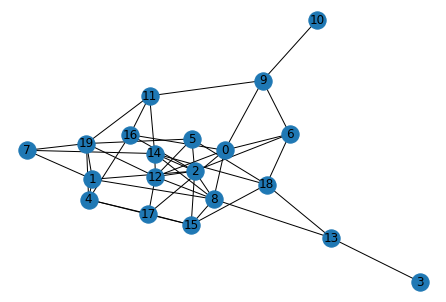

In [23]:
nx.draw(GG, with_labels = True)